In [3]:
import pickle
import numpy as np
import pandas as pd
import itertools

from scipy.stats import pearsonr, spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
print('rdkit version : ', rdkit.__version__)
import rdkit.Chem as chem
import rdkit.Chem.AllChem as allchem
from rdkit.Chem.Draw import rdMolDraw2D

!pip install mordred
import mordred
from mordred import Calculator, descriptors

#from RAscore import RAscore_XGB, RAscore_NN
#from SA_Score.sascorer import calculateScore
#from syba.syba import SybaClassifier

rdkit version :  2020.09.5


In [4]:
# utils/helper functions
def mfs(smiles):
    return chem.MolFromSmiles(smiles)

def mts(mol):
    return chem.MolToCXSmiles(mol)

In [5]:
# load the initial set
df = pd.read_csv('raw_data.csv')
# canonicalize smiles
smiles = df['SMILES'].tolist()
smiles = [chem.CanonSmiles(s) for s in smiles]
df['SMILES'] = smiles
print(df.shape)
print(df.columns)
df.head()

(1407, 7)
Index(['Entry Number', 'File Name', 'SMILES', 'Ered', 'HOMO', 'Gsol',
       'Absorption Wavelength'],
      dtype='object')


,Entry Number,File Name,SMILES,Ered,HOMO,Gsol,Absorption Wavelength
0,0,BTZ-Neutral-wb97xd-1000,CCOCN(C(C)=O)c1c(OC)c(C#N)c([N+](=O)[O-])c2nsnc12,3.006284,-8.811686,-0.790614,381.65
1,1,BTZ-Neutral-wb97xd-1001,CCOCN(C(C)=O)c1c(OC)c(C#N)c(S(=O)(=O)N(C)C)c2n...,2.511715,-8.794816,-1.096917,354.74
2,2,BTZ-Neutral-wb97xd-1002,CCOCN(C(C)=O)c1c(OC)c(OC)c(C)c2nsnc12,1.715196,-8.254153,-0.780220,334.28
3,3,BTZ-Neutral-wb97xd-1003,CCOCN(C(C)=O)c1c(OC)c(OC)c(C(F)(F)F)c2nsnc12,1.932468,-8.745838,-0.737337,319.72
4,4,BTZ-Neutral-wb97xd-1004,CCOCN(C(C)=O)c1c(OC)c(OC)c(C#N)c2nsnc12,2.198147,-8.643801,-0.828164,336.77


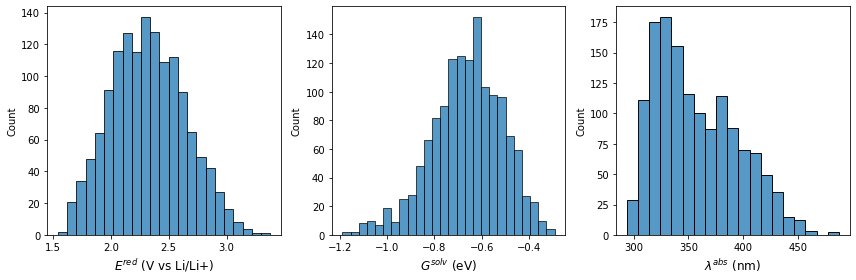

In [6]:
# plot properties 
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(df['Ered'], ax=axes[0])
axes[0].set_xlabel(r'$E^{red}$ (V vs Li/Li+)', fontsize=12)
sns.histplot(df['Gsol'], ax=axes[1])
axes[1].set_xlabel(r'$G^{solv}$ (eV)', fontsize=12)
sns.histplot(df['Absorption Wavelength'], ax=axes[2])
axes[2].set_xlabel(r'$\lambda^{abs}$ (nm)', fontsize=12)

plt.tight_layout()
plt.savefig('property_distributions.png', dpi=300)

In [7]:
# examine the first few molecules
samp_smiles = df['SMILES'].tolist()[0:20]
samp_mols = [chem.MolFromSmiles(s) for s in samp_smiles]

img = chem.Draw.MolsToGridImage(samp_mols, molsPerRow=10, subImgSize=(300, 300), returnPNG=False)
img.save('first_20.png')

## Problem setup
Dummy atoms: 
    R1 : He,
    R3 : Ne,
    R4 : Ar,
    R5 : Kr,

Possible functionalizations (chemical formula)

    R1 : -CH3, -CCOC, -CF2CF3
    R3 : -CH3, -CF3, -CN, -OCH3, -OCF3, -SCH3, -SCF3, -N(CH3)2
    R4 : -CH3, -CF3, -CN, -OCH3, -OCF3, -SCH3, -SCF3, -N(CH3)2
    R5 : -CH3, -CF3, -CN, -OCH3, -OCF3, -SCH3, -SCF3, -Br, -N(CH3)2, -NO2, -SO2N(CH3)2
    

In [8]:
core = mfs('CC(N([He])C1=C([Ne])C([Ar])=C([Kr])C2=NSN=C21)=O')

nei_map = {
        'He': 'N', # tertiary nitrogen
        'Ne': 'c', # aromatic carbon
        'Ar': 'c', # aromatic carbon
        'Kr': 'c', # aromatic carbon
}



r1_groups = [
#    {'label': 'R1_0', 'smiles': 'C[*]', 'atom_ix': 0, 'atom_sym': 'C'},
    {'label': 'R1_0', 'smiles': 'CCOC[*]', 'smiles_raw': 'CCOC', 'atom_ix': 3, 'atom_sym': 'C'},
    {'label': 'R1_1', 'smiles': 'FC(C(F)(F)F)([*])F', 'smiles_raw': 'FC(F)C(F)(F)F', 'atom_ix': 1, 'atom_sym': 'C'},
]

r3_groups = [
    {'label': 'R3_0', 'smiles': 'C[*]', 'smiles_raw': 'C', 'atom_ix': 0, 'atom_sym': 'C'},
    {'label': 'R3_1', 'smiles': 'FC(F)([*])F', 'smiles_raw': 'C(F)(F)F', 'atom_ix': 1, 'atom_sym': 'C'},
    {'label': 'R3_2', 'smiles': 'N#C[*]', 'smiles_raw': 'C#N', 'atom_ix': 1, 'atom_sym': 'C'},
    {'label': 'R3_3', 'smiles': 'CO[*]', 'smiles_raw': 'OC', 'atom_ix': 1, 'atom_sym': 'O'},
    {'label': 'R3_4', 'smiles': 'FC(F)(F)O[*]', 'smiles_raw': 'OC(F)(F)F', 'atom_ix': 4, 'atom_sym': 'O'},
    {'label': 'R3_5', 'smiles': 'CS[*]', 'smiles_raw': 'SC', 'atom_ix': 1, 'atom_sym': 'S'},
    {'label': 'R3_6', 'smiles': 'FC(F)(F)S[*]', 'smiles_raw': 'SC(F)(F)F', 'atom_ix': 4, 'atom_sym': 'S'},
    {'label': 'R3_7', 'smiles':  'CN([*])C', 'smiles_raw': 'N(C)C', 'atom_ix': 1, 'atom_sym': 'N'},
]

r4_groups = [
    {'label': 'R4_0', 'smiles': 'C[*]', 'smiles_raw': 'C', 'atom_ix': 0, 'atom_sym': 'C'},
    {'label': 'R4_1', 'smiles': 'FC(F)([*])F', 'smiles_raw': 'C(F)(F)F', 'atom_ix': 1, 'atom_sym': 'C'},
    {'label': 'R4_2', 'smiles': 'N#C[*]', 'smiles_raw': 'C#N', 'atom_ix': 1, 'atom_sym': 'C'},
    {'label': 'R4_3', 'smiles': 'CO[*]', 'smiles_raw': 'OC', 'atom_ix': 1, 'atom_sym': 'O'},
    {'label': 'R4_4', 'smiles': 'FC(F)(F)O[*]', 'smiles_raw': 'OC(F)(F)F', 'atom_ix': 4, 'atom_sym': 'O'},
    {'label': 'R4_5', 'smiles': 'CS[*]', 'smiles_raw': 'SC', 'atom_ix': 1, 'atom_sym': 'S'},
    {'label': 'R4_6', 'smiles': 'FC(F)(F)S[*]', 'smiles_raw': 'SC(F)(F)F', 'atom_ix': 4, 'atom_sym': 'S'},
    {'label': 'R4_7', 'smiles':  'CN([*])C', 'smiles_raw': 'N(C)C', 'atom_ix': 1, 'atom_sym': 'N'},
]


r5_groups = [
        {'label': 'R5_0', 'smiles': 'C[*]', 'smiles_raw': 'C', 'atom_ix': 0, 'atom_sym': 'C'},
        {'label': 'R5_1', 'smiles': 'FC(F)([*])F', 'smiles_raw': 'C(F)(F)F', 'atom_ix': 1, 'atom_sym': 'C'},
        {'label': 'R5_2', 'smiles': 'N#C[*]',  'smiles_raw': 'C#N', 'atom_ix': 1, 'atom_sym': 'C'},
        {'label': 'R5_3', 'smiles': 'CO[*]', 'smiles_raw': 'OC', 'atom_ix': 1, 'atom_sym': 'O'},
        {'label': 'R5_4', 'smiles': 'FC(F)(F)O[*]', 'smiles_raw': 'OC(F)(F)F', 'atom_ix': 4, 'atom_sym': 'O'},
        {'label': 'R5_5', 'smiles': 'CS[*]', 'smiles_raw': 'SC', 'atom_ix': 1, 'atom_sym': 'S'},
        {'label': 'R5_6', 'smiles': 'FC(F)(F)S[*]', 'smiles_raw': 'SC(F)(F)F', 'atom_ix': 0, 'atom_sym': 'S'},
        {'label': 'R5_7', 'smiles': 'Br[*]', 'smiles_raw': 'Br', 'atom_ix': 0, 'atom_sym': 'Br'},
        {'label': 'R5_8', 'smiles': 'CN([*])C', 'smiles_raw': 'N(C)C', 'atom_ix': 1, 'atom_sym': 'N'},
        {'label': 'R5_9', 'smiles': 'O=[N+]([O-])[*]', 'smiles_raw': 'N(=O)[O]', 'atom_ix': 1, 'atom_sym': 'N'},
        {'label': 'R5_10', 'smiles': 'CN(C)S(=O)([*])=O', 'smiles_raw': '[S](=O)(=O)N(C)C', 'atom_ix': 3, 'atom_sym': 'S'},
    ]

In [9]:
# GENERATE ALL MOLECULES
molecules = []

groups = [r1_groups, r3_groups, r4_groups, r5_groups]

all_combs = list(itertools.product(*groups))
print('LEN ALL COMBS : ', len(all_combs))
all_combs[365]


LEN ALL COMBS :  1408


({'label': 'R1_0',
  'smiles': 'CCOC[*]',
  'smiles_raw': 'CCOC',
  'atom_ix': 3,
  'atom_sym': 'C'},
 {'label': 'R3_4',
  'smiles': 'FC(F)(F)O[*]',
  'smiles_raw': 'OC(F)(F)F',
  'atom_ix': 4,
  'atom_sym': 'O'},
 {'label': 'R4_1',
  'smiles': 'FC(F)([*])F',
  'smiles_raw': 'C(F)(F)F',
  'atom_ix': 1,
  'atom_sym': 'C'},
 {'label': 'R5_2',
  'smiles': 'N#C[*]',
  'smiles_raw': 'C#N',
  'atom_ix': 1,
  'atom_sym': 'C'})

In [10]:
# loop through the combinations

mols = []

for comb in all_combs:
    
    r1_group = comb[0]
    r3_group = comb[1]
    r4_group = comb[2]
    r5_group = comb[3]
    
    # add the r1 group (He)
    # the N atom is 2, He atom is 3
    
    #-----------------
    # add the r1 group
    #-----------------
    atom_sym = r1_group['atom_sym']
    atom_ix = r1_group['atom_ix']
    rxn = allchem.ReactionFromSmarts(f'[N:2][He].[#0][{atom_sym}:{atom_ix}]>>[N:2]-[{atom_sym}:{atom_ix}]')
    reacts = (core, mfs(r1_group['smiles']))
    products = rxn.RunReactants(reacts)
#    print(len(products))
    product = products[0][0]
    
    
    #------------------
    # add the r3 group
    #------------------
    neighbor_idx = np.nan
    for atom in core.GetAtoms():
        if atom.GetSymbol() == 'Ne':
            neighbors = atom.GetNeighbors()
            assert len(neighbors)==1
            neighbor_idx = neighbors[0].GetIdx()
    
    atom_sym = r3_group['atom_sym']
    atom_ix = r3_group['atom_ix']
    rxn = allchem.ReactionFromSmarts(f'[c:{neighbor_idx}][Ne].[#0][{atom_sym}:{atom_ix}]>>[c:{neighbor_idx}]-[{atom_sym}:{atom_ix}]')
    reacts = (product, mfs(r3_group['smiles']))
    products = rxn.RunReactants(reacts)
#    print(len(products))
    product = products[0][0]
    
    #------------------
    # add the r4 group
    #------------------
    neighbor_idx = np.nan
    for atom in core.GetAtoms():
        if atom.GetSymbol() == 'Ar':
            neighbors = atom.GetNeighbors()
            assert len(neighbors)==1
            neighbor_idx = neighbors[0].GetIdx()
    
    atom_sym = r4_group['atom_sym']
    atom_ix = r4_group['atom_ix']
    rxn = allchem.ReactionFromSmarts(f'[c:{neighbor_idx}][Ar].[#0][{atom_sym}:{atom_ix}]>>[c:{neighbor_idx}]-[{atom_sym}:{atom_ix}]')
    reacts = (product, mfs(r4_group['smiles']))
    products = rxn.RunReactants(reacts)
#    print(len(products))
    product = products[0][0]
            
    
    #------------------
    # add the r5 group
    #------------------
    neighbor_idx = np.nan
    for atom in core.GetAtoms():
        if atom.GetSymbol() == 'Kr':
            neighbors = atom.GetNeighbors()
            assert len(neighbors)==1
            neighbor_idx = neighbors[0].GetIdx()
    
    atom_sym = r5_group['atom_sym']
    atom_ix = r5_group['atom_ix']
    rxn = allchem.ReactionFromSmarts(f'[c:{neighbor_idx}][Kr].[#0][{atom_sym}:{atom_ix}]>>[c:{neighbor_idx}]-[{atom_sym}:{atom_ix}]')
    reacts = (product, mfs(r5_group['smiles']))
    products = rxn.RunReactants(reacts)
#    print(len(products))
    product = products[0][0]
    prod_smiles = chem.CanonSmiles( mts(product) )
    
    # look up the smiles in dataframe
    match = df[df['SMILES']==prod_smiles].to_dict('r')

    if len(match)==1:
        
        ered = match[0]['Ered']
        gsol = match[0]['Gsol']
        abs_lam = match[0]['Absorption Wavelength']
        
        mols.append(
                {
                    'product_smiles': prod_smiles,
                    'r1_label': r1_group['label'],
                    'r1_smiles': r1_group['smiles'],
                    'r1_smiles_raw': r1_group['smiles_raw'],
                    'r3_label': r3_group['label'],
                    'r3_smiles': r3_group['smiles'],
                    'r3_smiles_raw': r3_group['smiles_raw'],
                    'r4_label': r4_group['label'],
                    'r4_smiles': r4_group['smiles'],
                    'r4_smiles_raw': r4_group['smiles_raw'],
                    'r5_label': r5_group['label'],
                    'r5_smiles': r5_group['smiles'],
                    'r5_smiles_raw': r5_group['smiles_raw'],
                    'ered': ered,
                    'gsol': gsol,
                    'abs_lam': abs_lam,
                }
        )

    
    
    
    
    

/home/riley/Software/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:84: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.


In [11]:
df_all = pd.DataFrame(mols)
# create a column that is abs_lam_diff from 375 nm (target wavelength in paper)
df_all['abs_lam_diff'] = np.abs(df_all['abs_lam']-375)
print(df_all.shape)
df_all.head()
df_all['r5_smiles_raw'].unique()

(1407, 17)


array(['C', 'C(F)(F)F', 'C#N', 'OC', 'OC(F)(F)F', 'SC', 'SC(F)(F)F', 'Br',
       'N(C)C', 'N(=O)[O]', '[S](=O)(=O)N(C)C'], dtype=object)

## Synthesizability cutoff analysis

In [10]:
smiles = df_all['product_smiles'].tolist()
mols = [mfs(s) for s in smiles]

In [11]:
xgb_scorer = RAscore_XGB.RAScorerXGB()
nn_scorer = RAscore_NN.RAScorerNN()

syba = SybaClassifier()
syba.fitDefaultScore()

In [12]:
ra_xgb = [xgb_scorer.predict(s) for s in smiles]
ra_nn = [nn_scorer.predict(s) for s in smiles]

In [13]:
sa_score = [calculateScore(m) for m in mols]

syba_score = [syba.predict(mol=m) for m in mols ]

In [14]:
df_all['ra_xgb'] = ra_xgb
df_all['ra_nn'] = ra_nn
df_all['sa_score'] = sa_score
df_all['syba'] = syba_score

In [15]:
df_all.head()

,product_smiles,r1_label,r1_smiles,r1_smiles_raw,r3_label,r3_smiles,r3_smiles_raw,r4_label,r4_smiles,r4_smiles_raw,...,r5_smiles,r5_smiles_raw,ered,gsol,abs_lam,abs_lam_diff,ra_xgb,ra_nn,sa_score,syba
0,CCOCN(C(C)=O)c1c(C)c(C)c(C)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,C[*],C,1.684123,-0.681801,335.04,39.96,0.927592,0.999163,3.175285,25.464101
1,CCOCN(C(C)=O)c1c(C)c(C)c(C(F)(F)F)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,FC(F)([*])F,C(F)(F)F,1.963624,-0.711542,311.08,63.92,0.961606,0.999867,3.336220,22.910623
2,CCOCN(C(C)=O)c1c(C)c(C)c(C#N)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,N#C[*],C#N,2.044655,-0.887400,323.24,51.76,0.955999,0.999329,3.286897,29.175360
3,CCOCN(C(C)=O)c1c(C)c(C)c(OC)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,CO[*],OC,1.731604,-0.710235,338.07,36.93,0.903359,0.994274,3.209570,27.575219
4,CCOCN(C(C)=O)c1c(C)c(C)c(OC(F)(F)F)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,FC(F)(F)O[*],OC(F)(F)F,1.844226,-0.748112,321.21,53.79,0.910281,0.799020,3.330460,27.326467


In [16]:
# save the dataframe to disk
df_all.to_csv('df_results.csv', index=False)

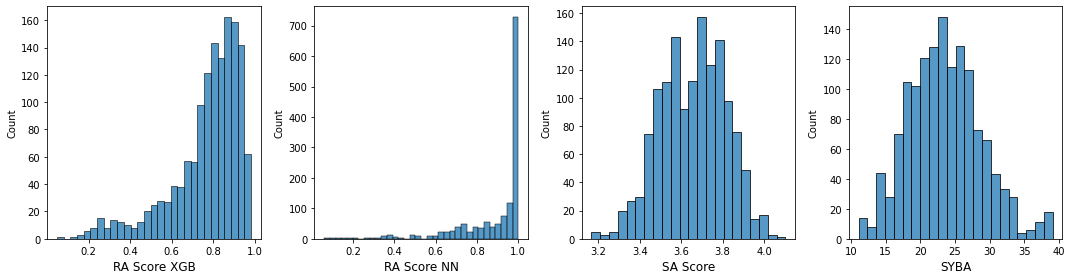

In [17]:
# plot properties 
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(df_all['ra_xgb'], ax=axes[0])
axes[0].set_xlabel('RA Score XGB', fontsize=12)
sns.histplot(df_all['ra_nn'], ax=axes[1])
axes[1].set_xlabel('RA Score NN', fontsize=12)
sns.histplot(df_all['sa_score'], ax=axes[2])
axes[2].set_xlabel('SA Score', fontsize=12)
sns.histplot(df_all['syba'], ax=axes[3])
axes[3].set_xlabel('SYBA', fontsize=12)

plt.tight_layout()
plt.savefig('synth_dists.png', dpi=300)

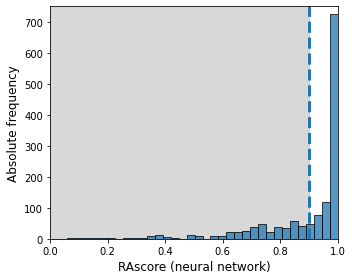

In [32]:
# single RA NN score plot

fig, ax = plt.subplots(1, 1, figsize=(5,4))


sns.histplot(df_all['ra_nn'], ax=ax)
ax.set_xlabel('RAscore (neural network)', fontsize=12)
ax.set_ylabel('Absolute frequency', fontsize=12)

ax.axvline(0.9, ls='--', lw=3,)
ax.fill_between(x=[0, 0.9], y1=0.0, y2=800., alpha=0.3, color='gray')

ax.set_xlim(0, 1)
ax.set_ylim(0, 750)

plt.tight_layout()
plt.savefig('rascore_nn.png', dpi=300)

In [18]:
def get_num_frags(frame, cutoff, score_type): 
    # apply synthesizability cutoff
    frame = frame[frame[score_type]>=cutoff]
    num_feas = frame.shape[0]
    num_r1 = len(frame['r1_label'].unique())
    num_r3 = len(frame['r3_label'].unique())
    num_r4 = len(frame['r4_label'].unique())
    num_r5 = len(frame['r5_label'].unique())
    
    return num_feas, num_r1, num_r3, num_r4, num_r5

def get_num_frags_sa(frame, cutoff, score_type='sa_score'): 
    # apply synthesizability cutoff
    frame = frame[frame[score_type]<=cutoff]
    num_feas = frame.shape[0]
    num_r1 = len(frame['r1_label'].unique())
    num_r3 = len(frame['r3_label'].unique())
    num_r4 = len(frame['r4_label'].unique())
    num_r5 = len(frame['r5_label'].unique())
    
    return num_feas, num_r1, num_r3, num_r4, num_r5


In [19]:
cutoffs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

num_feass = []
num_r1s = []
num_r2s = []
num_r3s = []
num_r4s = []
num_r5s = []

for cutoff in cutoffs:
    num_feas, num_r1, num_r3, num_r4, num_r5 = get_num_frags(df_all, cutoff, score_type='ra_xgb')
    num_feass.append(num_feas)
    num_r1s.append(num_r1)
    num_r3s.append(num_r3)
    num_r4s.append(num_r4)
    num_r5s.append(num_r5)
    

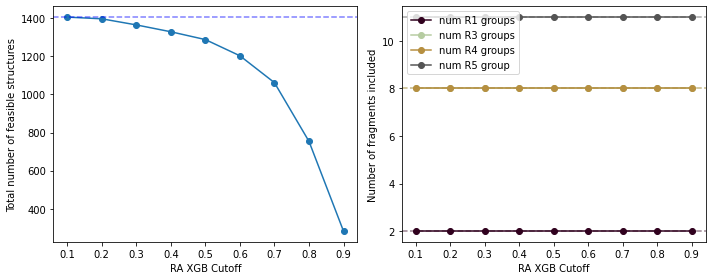

In [20]:
# RA XGB CUTOFF

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# total num 
axes[0].plot(cutoffs, num_feass, marker='o')
axes[0].axhline(y=1407, ls='--', c='b', alpha=0.5)
axes[0].set_xlabel('RA XGB Cutoff')
axes[0].set_ylabel('Total number of feasible structures')


# number of unique fragments
axes[1].plot(cutoffs, num_r1s, label='num R1 groups', marker='o', c='#30011e')
axes[1].axhline(y=2., c='#30011e', ls='--', alpha=0.5)

axes[1].plot(cutoffs, num_r3s, label='num R3 groups', marker='o', c='#b6cca1')
axes[1].axhline(y=8, ls='--', alpha=0.5, c='#b6cca1')

axes[1].plot(cutoffs, num_r4s, label='num R4 groups', marker='o', c='#b68f40')
axes[1].axhline(y=8., ls='--', alpha=0.5, c='#b68f40')

axes[1].plot(cutoffs, num_r5s, label='num R5 group', marker='o', c='#545454')
axes[1].axhline(y=11., ls='--', alpha=0.5, c='#545454')

axes[1].set_xlabel('RA XGB Cutoff')
axes[1].set_ylabel('Number of fragments included')

plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig('ra_xgb_cutoff_analysis.png', dpi=300)

In [21]:
cutoffs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

num_feass = []
num_r1s = []
num_r2s = []
num_r3s = []
num_r4s = []
num_r5s = []

for cutoff in cutoffs:
    num_feas, num_r1, num_r3, num_r4, num_r5 = get_num_frags(df_all, cutoff, score_type='ra_nn')
    num_feass.append(num_feas)
    num_r1s.append(num_r1)
    num_r3s.append(num_r3)
    num_r4s.append(num_r4)
    num_r5s.append(num_r5)

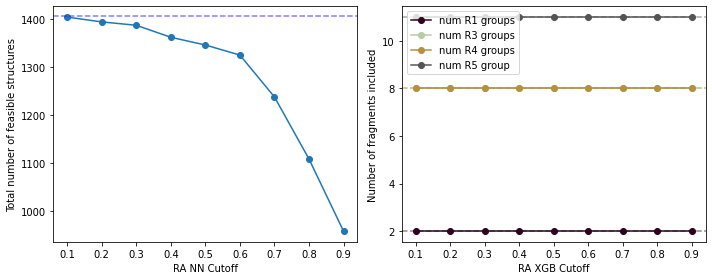

In [22]:
# RA NN CUTOFF

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# total num 
axes[0].plot(cutoffs, num_feass, marker='o')
axes[0].axhline(y=1407, ls='--', c='b', alpha=0.5)
axes[0].set_xlabel('RA NN Cutoff')
axes[0].set_ylabel('Total number of feasible structures')


# number of unique fragments
axes[1].plot(cutoffs, num_r1s, label='num R1 groups', marker='o', c='#30011e')
axes[1].axhline(y=2., c='#30011e', ls='--', alpha=0.5)

axes[1].plot(cutoffs, num_r3s, label='num R3 groups', marker='o', c='#b6cca1')
axes[1].axhline(y=8, ls='--', alpha=0.5, c='#b6cca1')

axes[1].plot(cutoffs, num_r4s, label='num R4 groups', marker='o', c='#b68f40')
axes[1].axhline(y=8., ls='--', alpha=0.5, c='#b68f40')

axes[1].plot(cutoffs, num_r5s, label='num R5 group', marker='o', c='#545454')
axes[1].axhline(y=11., ls='--', alpha=0.5, c='#545454')

axes[1].set_xlabel('RA XGB Cutoff')
axes[1].set_ylabel('Number of fragments included')

plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig('ra_nn_cutoff_analysis.png', dpi=300)

In [23]:
# SA SCORE CUTOFF ANALYSIS

cutoffs = [4.0, 3.9, 3.8, 3.7, 3.6, 3.5, 3.4, 3.3, 3.2]

num_feass = []
num_r1s = []
num_r2s = []
num_r3s = []
num_r4s = []
num_r5s = []

for cutoff in cutoffs:
    num_feas, num_r1, num_r3, num_r4, num_r5 = get_num_frags_sa(df_all, cutoff)
    num_feass.append(num_feas)
    num_r1s.append(num_r1)
    num_r3s.append(num_r3)
    num_r4s.append(num_r4)
    num_r5s.append(num_r5)

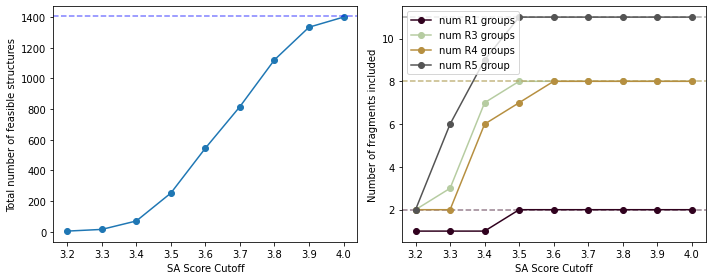

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# total num 
axes[0].plot(cutoffs, num_feass, marker='o')
axes[0].axhline(y=1407, ls='--', c='b', alpha=0.5)
axes[0].set_xlabel('SA Score Cutoff')
axes[0].set_ylabel('Total number of feasible structures')


# number of unique fragments
axes[1].plot(cutoffs, num_r1s, label='num R1 groups', marker='o', c='#30011e')
axes[1].axhline(y=2., c='#30011e', ls='--', alpha=0.5)

axes[1].plot(cutoffs, num_r3s, label='num R3 groups', marker='o', c='#b6cca1')
axes[1].axhline(y=8, ls='--', alpha=0.5, c='#b6cca1')

axes[1].plot(cutoffs, num_r4s, label='num R4 groups', marker='o', c='#b68f40')
axes[1].axhline(y=8., ls='--', alpha=0.5, c='#b68f40')

axes[1].plot(cutoffs, num_r5s, label='num R5 group', marker='o', c='#545454')
axes[1].axhline(y=11., ls='--', alpha=0.5, c='#545454')

axes[1].set_xlabel('SA Score Cutoff')
axes[1].set_ylabel('Number of fragments included')

plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig('sa_score_cutoff_analysis.png', dpi=300)

## Descriptor analysis

In [12]:
# load in the dataframe
# save the dataframe to disk
df_all = pd.read_csv('df_results.csv')
df_all.head()

,product_smiles,r1_label,r1_smiles,r1_smiles_raw,r3_label,r3_smiles,r3_smiles_raw,r4_label,r4_smiles,r4_smiles_raw,...,r5_smiles,r5_smiles_raw,ered,gsol,abs_lam,abs_lam_diff,ra_xgb,ra_nn,sa_score,syba
0,CCOCN(C(C)=O)c1c(C)c(C)c(C)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,C[*],C,1.684123,-0.681801,335.04,39.96,0.927592,0.999163,3.175285,25.464101
1,CCOCN(C(C)=O)c1c(C)c(C)c(C(F)(F)F)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,FC(F)([*])F,C(F)(F)F,1.963624,-0.711542,311.08,63.92,0.961606,0.999867,3.336220,22.910623
2,CCOCN(C(C)=O)c1c(C)c(C)c(C#N)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,N#C[*],C#N,2.044655,-0.887400,323.24,51.76,0.955999,0.999329,3.286897,29.175360
3,CCOCN(C(C)=O)c1c(C)c(C)c(OC)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,CO[*],OC,1.731604,-0.710235,338.07,36.93,0.903359,0.994274,3.209570,27.575219
4,CCOCN(C(C)=O)c1c(C)c(C)c(OC(F)(F)F)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,FC(F)(F)O[*],OC(F)(F)F,1.844226,-0.748112,321.21,53.79,0.910281,0.799020,3.330460,27.326467


In [13]:
r1_smiles = [s['smiles_raw'] for s in r1_groups]
r1_ix = [int(s['label'][3:]) for s in r1_groups]

r3_smiles = [s['smiles_raw'] for s in r3_groups]
r3_ix = [int(s['label'][3:]) for s in r3_groups]

r4_smiles = [s['smiles_raw'] for s in r4_groups]
r4_ix = [int(s['label'][3:]) for s in r4_groups]

r5_smiles = [s['smiles_raw'] for s in r5_groups]
r5_ix = [int(s['label'][3:]) for s in r5_groups]

full_smiles = list(set(df_all['product_smiles']))

r1_mols = [mfs(s) for s in r1_smiles]
type_r1 = ['R1' for _ in r1_mols]
r3_mols = [mfs(s) for s in r3_smiles]
type_r3 = ['R3' for _ in r3_mols]
r4_mols = [mfs(s) for s in r4_smiles]
type_r4 = ['R4' for _ in r4_mols]
r5_mols = [mfs(s) for s in r5_smiles]
type_r5 = ['R5' for _ in r5_mols]

full_mols = [mfs(s) for s in full_smiles]
type_full = ['full' for _ in full_smiles]

print(len(r1_mols), len(r3_mols), len(r4_mols), len(r5_mols), len(full_mols))

group_smiles = r1_smiles+r3_smiles+r4_smiles+r5_smiles
group_types = type_r1+type_r3+type_r4+type_r5
group_ixs = r1_ix+r3_ix+r4_ix+r5_ix
group_mols = r1_mols+r3_mols+r4_mols+r5_mols


2 8 8 11 1407


In [14]:
calc = Calculator(descriptors, ignore_3D=True)
df_mord_group  = calc.pandas(group_mols)

100%|███████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 43.39it/s]


In [15]:
mord_cols_ = df_mord_group.columns.tolist()


In [16]:
df_mord_group['smiles'] = group_smiles
df_mord_group['type'] = group_types
df_mord_group['ix'] = group_ixs
df_mord_group['mol'] = group_mols

cols_reorder = ['smiles', 'type', 'ix', 'mol'] + mord_cols_

df_mord_group = df_mord_group[cols_reorder]
df_mord_group.head()

,smiles,type,ix,mol,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CCOC,R1,0,<rdkit.Chem.rdchem.Mol object at 0x7fdd00934490>,2.121320,2.340100,0,0,4.472136,1.618034,...,5.509388,22.328143,60.057515,5.004793,10,1,10.0,8.0,2.5,1.25
1,FC(F)C(F)(F)F,R1,1,<rdkit.Chem.rdchem.Mol object at 0x7fdd00934170>,4.876567,5.209852,0,0,6.602720,2.175328,...,8.466531,34.219913,119.999841,14.999980,42,6,30.0,30.0,5.173611,1.50
2,C,R3,0,<rdkit.Chem.rdchem.Mol object at 0x7fdd00934710>,0.000000,0.000000,0,0,0.000000,0.000000,...,0.000000,1.000000,16.031300,3.206260,0,0,0.0,0.0,divide by zero encountered in power (mZagreb1),0.00
3,C(F)(F)F,R3,1,<rdkit.Chem.rdchem.Mol object at 0x7fdd009345d0>,2.449490,2.449490,0,0,3.464102,1.732051,...,6.188264,24.179697,70.003035,14.000607,9,0,12.0,9.0,3.111111,1.00
4,C#N,R3,2,<rdkit.Chem.rdchem.Mol object at 0x7fdd009344e0>,0.000000,0.000000,0,0,2.000000,1.000000,...,1.098612,7.493061,27.010899,9.003633,1,0,2.0,1.0,2.0,1.00


In [17]:
# parse the mordred descriptors
frag_smiles_mord = df_mord_group['smiles'].tolist()
desc_mord_group = df_mord_group.iloc[:, 3:]


# remove the non-numeric descriptors 
desc_mord_group = desc_mord_group.select_dtypes(exclude=['O', 'bool'])

# remove the descripors that have zero variance
num_unique = desc_mord_group.apply(pd.Series.nunique)
desc_mord_group = desc_mord_group.drop(num_unique[num_unique==1].index, axis=1)

# # compute the matrix of Pearson coefficients
# # skipping this, for now
# corrs = desc_mord_group.corr()
# redundant_desc = set()

# for i in range(corrs.shape[1]):
#     for j in range(i):
#         if np.abs(corrs.iloc[i, j]) > 0.9:
#             name = corrs.columns[i]
#             redundant_desc.add(name)
    
# remove the redundant descriptors
#desc_mord_group = desc_mord_group.drop(labels=redundant_desc, axis=1)  
print(desc_mord_group.shape)

(29, 594)


In [18]:
# add back the columns (sloppy)
desc_mord_group['smiles'] = df_mord_group['smiles']
desc_mord_group['type'] = df_mord_group['type']
desc_mord_group['ix'] = df_mord_group['ix']

In [19]:
# helper function

def get_desc(
        r1_ix, r3_ix, r4_ix, r5_ix,
): 
    """ return a df with one rwo comtaining the descriptors corresponding to the
    unique group indices 
    """
 
    # r1 label
    sub_df_mord  = desc_mord_group[
            (desc_mord_group['type']=='R1')&
            (desc_mord_group['ix']==r1_ix)
    ].iloc[:, 3:]
    assert sub_df_mord.shape[0] == 1 
    cols = sub_df_mord.columns.tolist()
    new_cols = ['_'.join(['r1', col]) for col in cols]
    sub_df_mord_r1 = sub_df_mord.rename(columns={col:ncol for col, ncol in zip(cols, new_cols)})
    
    # r3 label
    sub_df_mord  = desc_mord_group[
            (desc_mord_group['type']=='R3')&
            (desc_mord_group['ix']==r3_ix)
    ].iloc[:, 3:]
    assert sub_df_mord.shape[0] == 1 
    cols = sub_df_mord.columns.tolist()
    new_cols = ['_'.join(['r3', col]) for col in cols]
    sub_df_mord_r3 = sub_df_mord.rename(columns={col:ncol for col, ncol in zip(cols, new_cols)})
    
    # r4 label
    sub_df_mord  = desc_mord_group[
            (desc_mord_group['type']=='R4')&
            (desc_mord_group['ix']==r4_ix)
    ].iloc[:, 3:]
    assert sub_df_mord.shape[0] == 1 
    cols = sub_df_mord.columns.tolist()
    new_cols = ['_'.join(['r4', col]) for col in cols]
    sub_df_mord_r4 = sub_df_mord.rename(columns={col:ncol for col, ncol in zip(cols, new_cols)})
    
    
    # r5 label
    sub_df_mord  = desc_mord_group[
            (desc_mord_group['type']=='R5')&
            (desc_mord_group['ix']==r5_ix)
    ].iloc[:, 3:]
    assert sub_df_mord.shape[0] == 1 
    cols = sub_df_mord.columns.tolist()
    new_cols = ['_'.join(['r5', col]) for col in cols]
    sub_df_mord_r5 = sub_df_mord.rename(columns={col:ncol for col, ncol in zip(cols, new_cols)})
    
    
    # concatenate everything together
    dfs = [
       sub_df_mord_r1, sub_df_mord_r3, sub_df_mord_r4, sub_df_mord_r5 
    ]
    
    desc = {}
    for d in dfs:
        cols = d.columns
        for col in cols:
            desc[col] = d[col].tolist()
            
    return pd.DataFrame(desc)
    

In [20]:
desc = get_desc(0, 0, 0, 0)
desc

,r1_SpAbs_A,r1_SpMax_A,r1_SpDiam_A,r1_SpAD_A,r1_SpMAD_A,r1_LogEE_A,r1_VE1_A,r1_VE2_A,r1_VE3_A,r1_VR1_A,...,r5_MW,r5_AMW,r5_WPath,r5_WPol,r5_Zagreb1,r5_Zagreb2,r5_mZagreb2,r5_smiles,r5_type,r5_ix
0,4.472136,1.618034,3.236068,4.472136,1.118034,2.155909,1.946498,0.486624,-0.250259,5.891993,...,16.0313,3.20626,0,0,0.0,0.0,0.0,C,R5,0


In [ ]:
all_desc = []
for ix, row in df_all.iterrows():
    row = row.to_dict()
    r1_ix = int(row['r1_label'][3:])
    r3_ix = int(row['r3_label'][3:])
    r4_ix = int(row['r4_label'][3:])
    r5_ix = int(row['r5_label'][3:])
    
    desc = get_desc(r1_ix, r3_ix, r4_ix, r5_ix)
    
    all_desc.append(desc)

In [ ]:
all_desc = pd.concat(all_desc)
all_desc.head()

In [ ]:
# make the final dataframe
df_final = {}
for d in [df_all, all_desc]:
    cols = d.columns.tolist()
    for col in cols:
        df_final[col] = d[col].tolist()
df_final = pd.DataFrame(df_final)

print(df_final.shape, 14+789)
df_final.head()

In [ ]:
# save the df final to disk (all smiles, groups, objectives and descriptors)
df_final.to_csv('df_results.csv')

In [37]:
# get the relevant columns for each fragment
r1_cols = [col for col in df_final.columns.tolist() if col.startswith('r1')]
r3_cols = [col for col in df_final.columns.tolist() if col.startswith('r3')]
r4_cols = [col for col in df_final.columns.tolist() if col.startswith('r4')]
r5_cols = [col for col in df_final.columns.tolist() if col.startswith('r5')]


r1_cols = [col for col in r1_cols if not col in ['r1_label', 'r1_smiles', 'r1_smiles_raw', 'r1_type', 'r1_ix']]
r3_cols = [col for col in r3_cols if not col in ['r3_label', 'r3_smiles', 'r3_smiles_raw', 'r3_type', 'r3_ix']]
r4_cols = [col for col in r4_cols if not col in ['r4_label', 'r4_smiles', 'r4_smiles_raw', 'r4_type', 'r4_ix']]
r5_cols = [col for col in r5_cols if not col in ['r5_label', 'r5_smiles', 'r5_smiles_raw', 'r5_type', 'r5_ix']]

In [38]:
PROPS = ['ered', 'gsol', 'abs_lam_diff'] 

corrs = []

# r1 
for prop in PROPS:
    prop_vals = df_final[prop].values
    for col in r1_cols:
        desc_vals = df_final[col].values.astype(np.float32)

        corr = pearsonr(prop_vals.ravel(), desc_vals.ravel())[0]
        
        corrs.append(
            {
                'prop': prop,
                'desc': col,
                'group_type': 'r1',
                'corr': corr,
            }
        )

# r3
for prop in PROPS:
    prop_vals = df_final[prop].values
    for col in r3_cols:
        desc_vals = df_final[col].values.astype(np.float32)

        corr = pearsonr(prop_vals.ravel(), desc_vals.ravel())[0]
        
        corrs.append(
            {
                'prop': prop,
                'desc': col,
                'group_type': 'r3',
                'corr': corr,
            }
        )
            
# r4 
for prop in PROPS:
    prop_vals = df_final[prop].values
    for col in r4_cols:
        desc_vals = df_final[col].values.astype(np.float32)

        corr = pearsonr(prop_vals.ravel(), desc_vals.ravel())[0]
        
        corrs.append(
            {
                'prop': prop,
                'desc': col,
                'group_type': 'r4',
                'corr': corr,
            }
        )
        
# r5
for prop in PROPS:
    prop_vals = df_final[prop].values
    for col in r5_cols:
        desc_vals = df_final[col].values.astype(np.float32)

        corr = pearsonr(prop_vals.ravel(), desc_vals.ravel())[0]
        
        corrs.append(
            {
                'prop': prop,
                'desc': col,
                'group_type': 'r5',
                'corr': corr,
            }
        )
        
        
df_corr = pd.DataFrame(corrs)
df_corr['abs_corr'] = df_corr['corr'].abs()
print('df_corr shape : ', df_corr.shape)
df_corr.head()

/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


df_corr shape :  (7092, 5)


,prop,desc,group_type,corr,abs_corr
0,ered,r1_SpAbs_A,r1,0.223757,0.223757
1,ered,r1_SpMax_A,r1,0.223757,0.223757
2,ered,r1_SpDiam_A,r1,0.223757,0.223757
3,ered,r1_SpAD_A,r1,0.223757,0.223757
4,ered,r1_SpMAD_A,r1,-0.223757,0.223757


In [43]:

# intuitive_desc = [
#     'nAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nHetero', 'nBonds', 'nBondsD', 
#     'nBondsT', 'C1SP1', 'C2SP1', 'C1SP2', 'C2SP2', 'C3SP2', 'C1SP3', 'C2SP3', 
#     'C3SP3', 'C4SP3', 'HybRatio', 'FCSP3', 'GeomDiameter', 'GeomRadius', 'HBAcc', 'nHBDon', 
#     'nRing', 'apol', 'bpol', 'nRot', 'RotRatio', 'TopoPSA', 'Diameter', 'Radius', 'MW',
# ]

intuitive_desc = [
    'nHetero', 'MW', 'TopoPSA', 'nHeavyAtom', 'apol', 'FCSP3', 'Diameter'
]

# add on the frags
r1 = ['_'.join(['r1', d]) for d in intuitive_desc]
r3 = ['_'.join(['r3', d]) for d in intuitive_desc]
r4 = ['_'.join(['r4', d]) for d in intuitive_desc]
r5 = ['_'.join(['r5', d]) for d in intuitive_desc]
intuitive_desc = r1+r3+r4+r5

# get subdf of intutitive descriptor correlations
intuit_corrs = df_corr[df_corr['desc'].isin(intuitive_desc)]

/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


     prop           desc group_type      corr  abs_corr
12   ered  r1_nHeavyAtom         r1  0.223757  0.223757
13   ered     r1_nHetero         r1  0.223757  0.223757
337  ered       r1_FCSP3         r1       NaN       NaN
552  ered        r1_apol         r1 -0.223757  0.223757
558  ered     r1_TopoPSA         r1 -0.223757  0.223757
564  ered    r1_Diameter         r1       NaN       NaN
584  ered          r1_MW         r1  0.223757  0.223757
      prop           desc group_type      corr  abs_corr
1785  ered  r3_nHeavyAtom         r3  0.216594  0.216594
1786  ered     r3_nHetero         r3  0.266979  0.266979
2110  ered       r3_FCSP3         r3 -0.312673  0.312673
2325  ered        r3_apol         r3 -0.258572  0.258572
2331  ered     r3_TopoPSA         r3  0.128901  0.128901
2337  ered    r3_Diameter         r3  0.162374  0.162374
2357  ered          r3_MW         r3  0.207784  0.207784
      prop           desc group_type      corr  abs_corr
3558  ered  r4_nHeavyAtom         r4  0

/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


      prop           desc group_type      corr  abs_corr
603   gsol  r1_nHeavyAtom         r1  0.622701  0.622701
604   gsol     r1_nHetero         r1  0.622701  0.622701
928   gsol       r1_FCSP3         r1       NaN       NaN
1143  gsol        r1_apol         r1 -0.622701  0.622701
1149  gsol     r1_TopoPSA         r1 -0.622701  0.622701
1155  gsol    r1_Diameter         r1       NaN       NaN
1175  gsol          r1_MW         r1  0.622701  0.622701
      prop           desc group_type      corr  abs_corr
2376  gsol  r3_nHeavyAtom         r3  0.220708  0.220708
2377  gsol     r3_nHetero         r3  0.243270  0.243270
2701  gsol       r3_FCSP3         r3  0.126464  0.126464
2916  gsol        r3_apol         r3 -0.064257  0.064257
2922  gsol     r3_TopoPSA         r3 -0.001489  0.001489
2928  gsol    r3_Diameter         r3  0.135560  0.135560
2948  gsol          r3_MW         r3  0.226762  0.226762
      prop           desc group_type      corr  abs_corr
4149  gsol  r4_nHeavyAtom      

/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/riley/anaconda3/envs/feas/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


              prop           desc group_type      corr  abs_corr
1194  abs_lam_diff  r1_nHeavyAtom         r1  0.167504  0.167504
1195  abs_lam_diff     r1_nHetero         r1  0.167504  0.167504
1519  abs_lam_diff       r1_FCSP3         r1       NaN       NaN
1734  abs_lam_diff        r1_apol         r1 -0.167504  0.167504
1740  abs_lam_diff     r1_TopoPSA         r1 -0.167504  0.167504
1746  abs_lam_diff    r1_Diameter         r1       NaN       NaN
1766  abs_lam_diff          r1_MW         r1  0.167504  0.167504
              prop           desc group_type      corr  abs_corr
2967  abs_lam_diff  r3_nHeavyAtom         r3  0.091835  0.091835
2968  abs_lam_diff     r3_nHetero         r3  0.125818  0.125818
3292  abs_lam_diff       r3_FCSP3         r3 -0.107546  0.107546
3507  abs_lam_diff        r3_apol         r3 -0.252901  0.252901
3513  abs_lam_diff     r3_TopoPSA         r3 -0.117246  0.117246
3519  abs_lam_diff    r3_Diameter         r3  0.016301  0.016301
3539  abs_lam_diff       

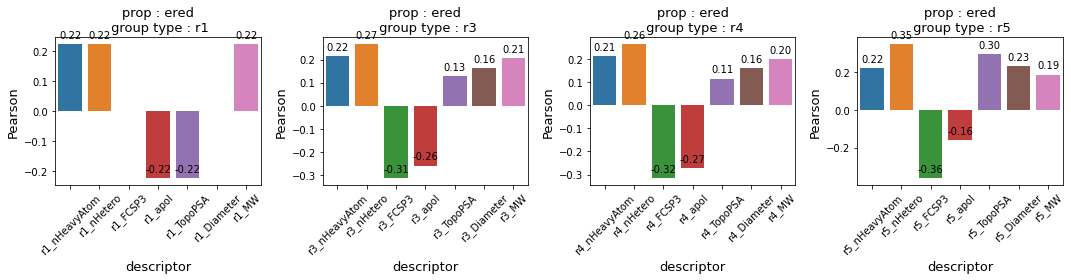

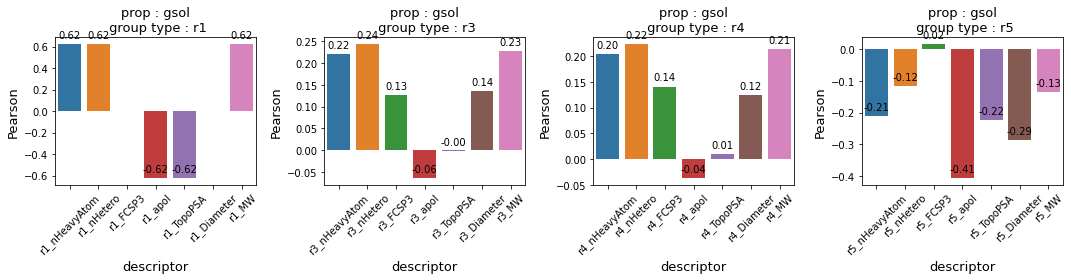

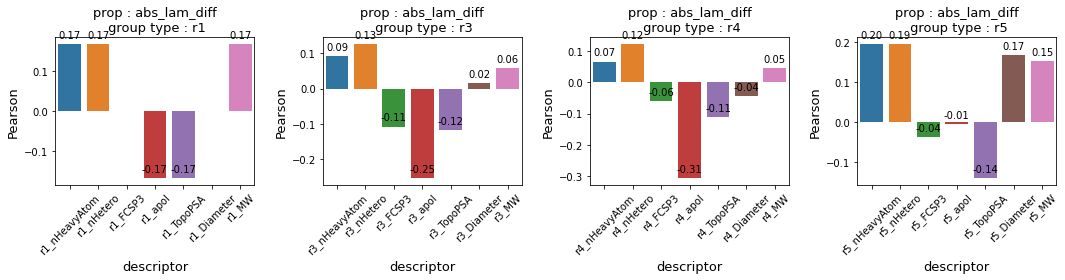

In [50]:
PROPS = ['ered', 'gsol', 'abs_lam_diff']

for prop in PROPS:
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    axes=axes.flatten()
    
    for ix, frag_type in enumerate(['r1', 'r3', 'r4', 'r5']):
        
        # sort descending by corr and get the top 10 descriptors by correlation
        sub = intuit_corrs[(intuit_corrs['prop']==prop) &
                (df_corr['group_type']==frag_type)
            ]#.sort_values(by='abs_corr', ascending=False).iloc[:10, :]
        
        print(sub)
        b_ = sns.barplot(
            data=sub,
            x='desc',
            y='corr', 
            ax=axes[ix],
        )
        for p in b_.patches:
            b_.annotate(format(p.get_height(), '.2f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', 
                        xytext=(0,9),
                        textcoords='offset points')
        
        axes[ix].set_title(f'prop : {prop}\n group type : {frag_type}', fontsize=13)
        axes[ix].tick_params(axis='x', rotation=45,)
        
        axes[ix].set_xlabel('descriptor', fontsize=13)
        axes[ix].set_ylabel('Pearson', fontsize=13)
        
        
        
    plt.tight_layout()
    
    plt.savefig(f'corrs_{prop}.png', dpi=300)

In [60]:
df_all

,product_smiles,r1_label,r1_smiles,r1_smiles_raw,r3_label,r3_smiles,r3_smiles_raw,r4_label,r4_smiles,r4_smiles_raw,...,r5_smiles,r5_smiles_raw,ered,gsol,abs_lam,abs_lam_diff,ra_xgb,ra_nn,sa_score,syba
0,CCOCN(C(C)=O)c1c(C)c(C)c(C)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,C[*],C,1.684123,-0.681801,335.04,39.96,0.927592,0.999163,3.175285,25.464101
1,CCOCN(C(C)=O)c1c(C)c(C)c(C(F)(F)F)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,FC(F)([*])F,C(F)(F)F,1.963624,-0.711542,311.08,63.92,0.961606,0.999867,3.336220,22.910623
2,CCOCN(C(C)=O)c1c(C)c(C)c(C#N)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,N#C[*],C#N,2.044655,-0.887400,323.24,51.76,0.955999,0.999329,3.286897,29.175360
3,CCOCN(C(C)=O)c1c(C)c(C)c(OC)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,CO[*],OC,1.731604,-0.710235,338.07,36.93,0.903359,0.994274,3.209570,27.575219
4,CCOCN(C(C)=O)c1c(C)c(C)c(OC(F)(F)F)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,FC(F)(F)O[*],OC(F)(F)F,1.844226,-0.748112,321.21,53.79,0.910281,0.799020,3.330460,27.326467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,CC(=O)N(c1c(N(C)C)c(N(C)C)c(SC(F)(F)F)c2nsnc12...,R1_1,FC(C(F)(F)F)([*])F,FC(F)C(F)(F)F,R3_7,CN([*])C,N(C)C,R4_7,CN([*])C,N(C)C,...,FC(F)(F)S[*],SC(F)(F)F,1.953747,-0.645258,403.60,28.60,0.814161,0.839460,3.867547,20.570796
1403,CC(=O)N(c1c(N(C)C)c(N(C)C)c(Br)c2nsnc12)C(F)(F...,R1_1,FC(C(F)(F)F)([*])F,FC(F)C(F)(F)F,R3_7,CN([*])C,N(C)C,R4_7,CN([*])C,N(C)C,...,Br[*],Br,1.921802,-0.576308,387.22,12.22,0.879521,0.995000,3.723898,20.720007
1404,CC(=O)N(c1c(N(C)C)c(N(C)C)c(N(C)C)c2nsnc12)C(F...,R1_1,FC(C(F)(F)F)([*])F,FC(F)C(F)(F)F,R3_7,CN([*])C,N(C)C,R4_7,CN([*])C,N(C)C,...,CN([*])C,N(C)C,1.895517,-0.614102,400.32,25.32,0.792721,0.874111,3.739789,21.387355
1405,CC(=O)N(c1c(N(C)C)c(N(C)C)c([N+](=O)[O-])c2nsn...,R1_1,FC(C(F)(F)F)([*])F,FC(F)C(F)(F)F,R3_7,CN([*])C,N(C)C,R4_7,CN([*])C,N(C)C,...,O=[N+]([O-])[*],N(=O)[O],2.129904,-0.731976,419.07,44.07,0.754213,0.995217,3.739538,24.519447


In [43]:
sample_smiles = 'CCOCN(C(C)=O)c1c(OC)c(C#N)c(N(C)C)c2nsnc12'


In [46]:
row = df_all[df_all['product_smiles']==sample_smiles].iloc[0, ]
row

product_smiles    CCOCN(C(C)=O)c1c(OC)c(C#N)c(N(C)C)c2nsnc12
r1_label                                                R1_0
r1_smiles                                            CCOC[*]
r1_smiles_raw                                           CCOC
r3_label                                                R3_3
r3_smiles                                              CO[*]
r3_smiles_raw                                             OC
r4_label                                                R4_2
r4_smiles                                             N#C[*]
r4_smiles_raw                                            C#N
r5_label                                                R5_8
r5_smiles                                           CN([*])C
r5_smiles_raw                                          N(C)C
ered                                                1.925666
gsol                                               -0.913494
abs_lam                                                410.5
abs_lam_diff            

In [54]:
df_constr = df_all[(df_all['abs_lam_diff']<25) & (df_all['ered']<2.0) & (df_all['ra_nn']>0.9)]
#df_constr = df_all[df_all['ered']<2.0]
print(df_constr.shape)
df_constr.head()

(81, 21)


,product_smiles,r1_label,r1_smiles,r1_smiles_raw,r3_label,r3_smiles,r3_smiles_raw,r4_label,r4_smiles,r4_smiles_raw,...,r5_smiles,r5_smiles_raw,ered,gsol,abs_lam,abs_lam_diff,ra_xgb,ra_nn,sa_score,syba
5,CCOCN(C(C)=O)c1c(C)c(C)c(SC)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,CS[*],SC,1.831274,-0.740439,350.93,24.07,0.918846,0.994274,3.413155,20.736180
8,CCOCN(C(C)=O)c1c(C)c(C)c(N(C)C)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_0,C[*],C,...,CN([*])C,N(C)C,1.624642,-0.811565,395.18,20.18,0.956582,0.999114,3.323000,27.457785
38,CCOCN(C(C)=O)c1c(C)c(OC)c(SC)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_3,CO[*],OC,...,CS[*],SC,1.797044,-0.737908,352.51,22.49,0.910237,0.999986,3.431896,23.709169
47,CCOCN(C(C)=O)c1c(C)c(OC(F)(F)F)c(OC)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_4,FC(F)(F)O[*],OC(F)(F)F,...,CO[*],OC,1.921367,-0.626592,356.40,18.60,0.803440,0.999890,3.350027,30.401622
58,CCOCN(C(C)=O)c1c(C)c(SC)c(OC)c2nsnc12,R1_0,CCOC[*],CCOC,R3_0,C[*],C,R4_5,CS[*],SC,...,CO[*],OC,1.888633,-0.709038,367.99,7.01,0.972210,0.999986,3.452054,23.709169


<AxesSubplot:xlabel='gsol', ylabel='Count'>

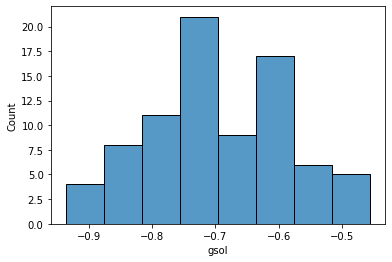

In [55]:
sns.histplot(df_constr['gsol'])

In [63]:
# compute the pairwise correlations between the vectors 
# of descriptors and themselves

intuitive_desc = [
    'nHetero', 'MW', 'TopoPSA', 'nHeavyAtom', 'apol', 'FCSP3', 'Diameter'
]

# df_corr_intuit = df_corr[df_corr['desc'].isin(intuitive_desc)]
# print(df_corr_intuit.shape)
# df_corr_intuit.head()


intuitive_desc = [
    'nHetero', 'MW', 'TopoPSA', 'nHeavyAtom', 'apol', 'FCSP3', 'Diameter'
]

# add on the frags
r1 = ['_'.join(['r1', d]) for d in intuitive_desc]
r3 = ['_'.join(['r3', d]) for d in intuitive_desc]
r4 = ['_'.join(['r4', d]) for d in intuitive_desc]
r5 = ['_'.join(['r5', d]) for d in intuitive_desc]
intuitive_desc = r1+r3+r4+r5

print(intuitive_desc)

intuitive_desc_gen = [
    'nHetero', 'MW', 'TopoPSA', 'nHeavyAtom', 'apol', 'FCSP3', 'Diameter'
]


['r1_nHetero', 'r1_MW', 'r1_TopoPSA', 'r1_nHeavyAtom', 'r1_apol', 'r1_FCSP3', 'r1_Diameter', 'r3_nHetero', 'r3_MW', 'r3_TopoPSA', 'r3_nHeavyAtom', 'r3_apol', 'r3_FCSP3', 'r3_Diameter', 'r4_nHetero', 'r4_MW', 'r4_TopoPSA', 'r4_nHeavyAtom', 'r4_apol', 'r4_FCSP3', 'r4_Diameter', 'r5_nHetero', 'r5_MW', 'r5_TopoPSA', 'r5_nHeavyAtom', 'r5_apol', 'r5_FCSP3', 'r5_Diameter']


In [65]:
pairwise_corrs = np.empty((len(intuitive_desc_gen), len(intuitive_desc_gen)))

for i1, d1 in enumerate(intuitive_desc_gen):
    for i2, d2 in enumerate(intuitive_desc_gen): 
        
        frags = [1, 3, 4, 5]
        arrays1 = [df_final[f'r{f}_{d1}'].values for f in frags]
        arrays2 = [df_final[f'r{f}_{d2}'].values for f in frags]
        
        array1 = np.concatenate(arrays1)
        array2 = np.concatenate(arrays2)
        
        #print(array1.shape, array2.shape)
        
        pairwise_corrs[i1, i2] = pearsonr(array1, array2)[0]
        
        

<AxesSubplot:>

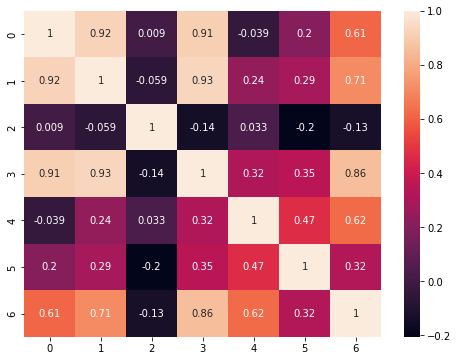

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(pairwise_corrs, annot=True)